## MaxCut Problem

The **MaxCut problem** is a combinatorial optimization problem where the goal is to partition the vertices of a graph into two disjoint subsets such that the number (or weight) of edges between the subsets is maximized.

### Definition:
Given:
- A graph \( G = (V, E) \) where \( V \) is the set of vertices and \( E \) is the set of edges,
- Each edge $( (u, v) \in E )$ may have a weight $( w_{uv} )$,

The objective is to find a partition \( (S, T) \) of \( V \) such that the sum of weights of edges crossing between \( S \) and \( T \) is maximized.

The MaxCut problem is **NP-hard**, meaning there is no known polynomial-time solution for all cases, but approximation algorithms and quantum approaches (e.g., QAOA) can be used to find near-optimal solutions efficiently.


## References
[1] Solve utility-scale quantum optimization problems:  
[qiskit QAOA](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)\
[2] MaxCut by BallBoii:  
[Maxcut_tutorial.ipynb](https://github.com/BallBoii/Maxcut_Tutorial/blob/main/Maxcut_tutorial.ipynb)



## Unweighted MaxCut

matrix([[0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
        [1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.]])

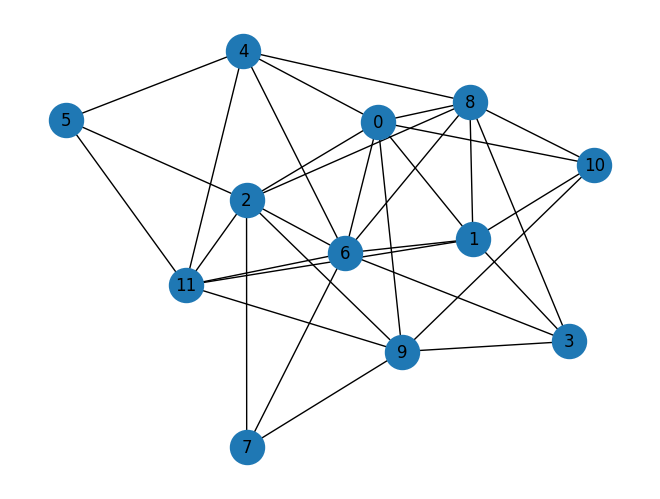

In [1]:
from maxcut import MaxCut

maxcut = MaxCut(12, 125)
maxcut.weight_matrix

In [2]:
qubo = maxcut.qubo("Qiskit")
cost_hamiltonian, offset = qubo['model'], qubo['offset']
print(f"====Cost Hamiltonian directly====")
print(maxcut.build_max_cut_paulis(), '\n')
print(f"====Cost Hamiltonian from qubo====")
print(cost_hamiltonian, f"{offset=}", sep='\n')


====Cost Hamiltonian directly====
SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIZIIIZ', 'IIIIIZIIIIIZ', 'IIIZIIIIIIIZ', 'IIZIIIIIIIIZ', 'IZIIIIIIIIIZ', 'IIIIIIIIZIZI', 'IIIIIZIIIIZI', 'IIIZIIIIIIZI', 'IZIIIIIIIIZI', 'ZIIIIIIIIIZI', 'IIIIIIZIIZII', 'IIIIIZIIIZII', 'IIIIZIIIIZII', 'IIIZIIIIIZII', 'IIZIIIIIIZII', 'ZIIIIIIIIZII', 'IIIIIZIIZIII', 'IIIZIIIIZIII', 'IIZIIIIIZIII', 'IIIIIIZZIIII', 'IIIIIZIZIIII', 'IIIZIIIZIIII', 'ZIIIIIIZIIII', 'ZIIIIIZIIIII', 'IIIIZZIIIIII', 'IIIZIZIIIIII', 'ZIIIIZIIIIII', 'IIZIZIIIIIII', 'IZIZIIIIIIII', 'IZZIIIIIIIII', 'ZIZIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]) 

====Cost Hamiltonian from qubo====
SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIZIIIZ', 'IIIIIZIIIIIZ', 'IIIZIIIIIIIZ', 

## Solve locally

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])


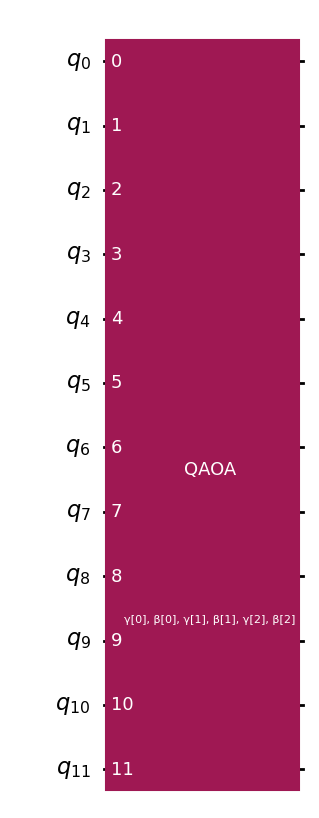

In [3]:
from qiskit.circuit.library import QAOAAnsatz

reps = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
print(circuit.parameters)
circuit.draw('mpl')

## Optimizing circuit

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.0631466488998225
       x: [ 3.140e+00  1.882e+00  3.161e+00  1.985e+00  3.886e+00
            3.098e+00]
    nfev: 57
   maxcv: 0.0


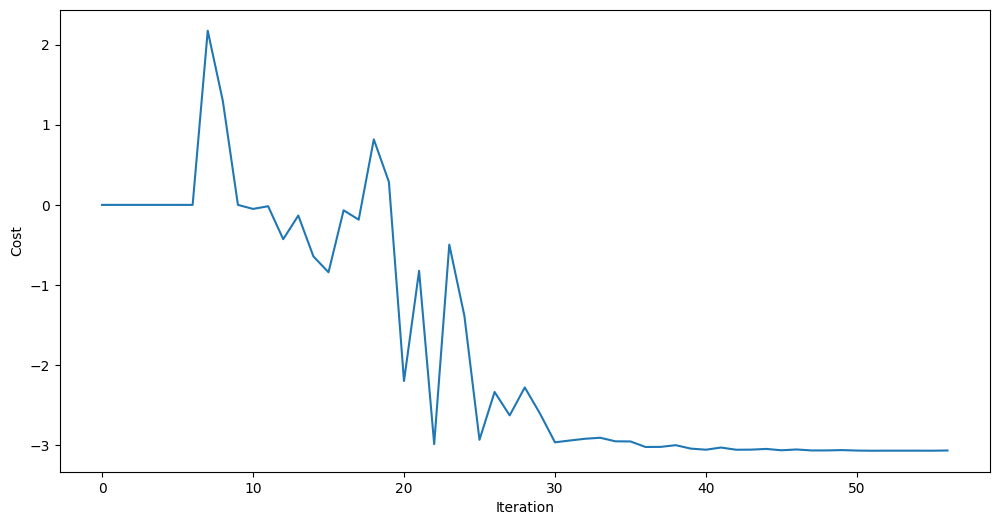

-19.563146648899824


In [4]:
from utils import QAOA
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator

qaoa = QAOA(circuit, reps=reps)

estimator = Estimator()

result = minimize(
    qaoa.cost_func_estimator,
    qaoa.init_params,
    args=(cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)

print(result)
cost = qaoa.draw_cost_function()
print(cost + offset)

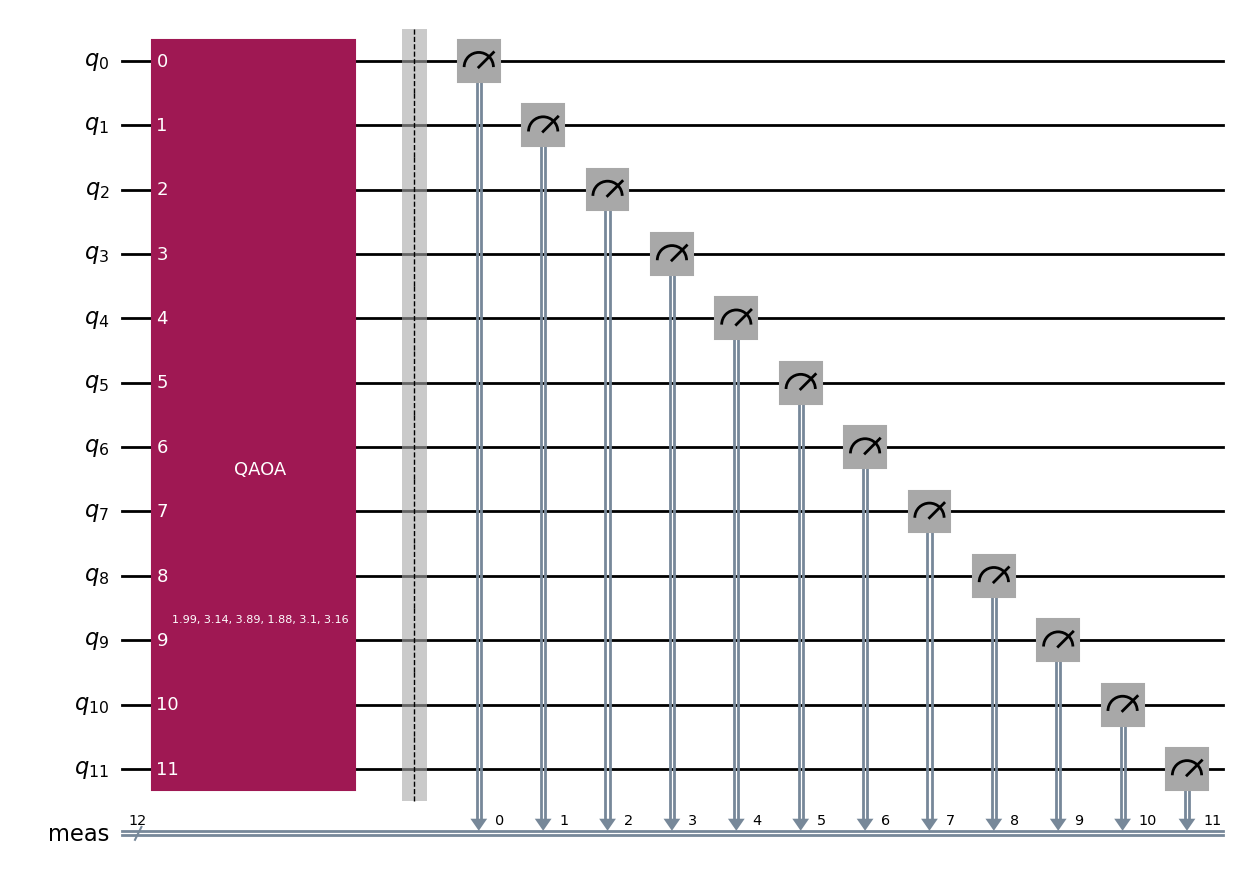

In [5]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

## Run sampling

In [6]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(default_shots=10000)
# sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
result = job.result()

most_likely_bitstring = maxcut.interpret(result, "Qiskit", True)
print("Result bitstring:", most_likely_bitstring)

distribution: 
 {3502: 0.0004, 3862: 0.0006, 2421: 0.0001, 2710: 0.0007, 3133: 0.0006, 3366: 0.0003, 3211: 0.0005, 2579: 0.0006, 1656: 0.0009, 2862: 0.0003, 3010: 0.0006, 2631: 0.0008, 1942: 0.0005, 762: 0.0008, 1348: 0.0005, 2175: 0.0001, 630: 0.0024, 604: 0.0011, 1638: 0.0036, 3552: 0.0017, 574: 0.0015, 3136: 0.0003, 2207: 0.0022, 3290: 0.0005, 1628: 0.0026, 3186: 0.0001, 3041: 0.002, 1244: 0.0012, 407: 0.0005, 608: 0.0003, 1784: 0.0008, 413: 0.0011, 2448: 0.0001, 443: 0.0011, 2947: 0.0013, 1118: 0.0018, 2034: 0.0003, 543: 0.0015, 2467: 0.0025, 4004: 0.0001, 3219: 0.0008, 1462: 0.0008, 2657: 0.0005, 2667: 0.0002, 1452: 0.0006, 1937: 0.0002, 3372: 0.0009, 884: 0.0005, 3169: 0.0008, 1478: 0.0004, 2119: 0.0005, 3222: 0.0011, 542: 0.0011, 837: 0.0007, 1619: 0.0001, 807: 0.001, 702: 0.0006, 3193: 0.0005, 2439: 0.0016, 3230: 0.0038, 1001: 0.0006, 950: 0.0009, 3149: 0.0025, 2629: 0.0002, 1213: 0.0017, 3280: 0.0002, 1380: 0.0008, 748: 0.0001, 481: 0.0003, 3143: 0.0003, 670: 0.0023, 599: 0.00

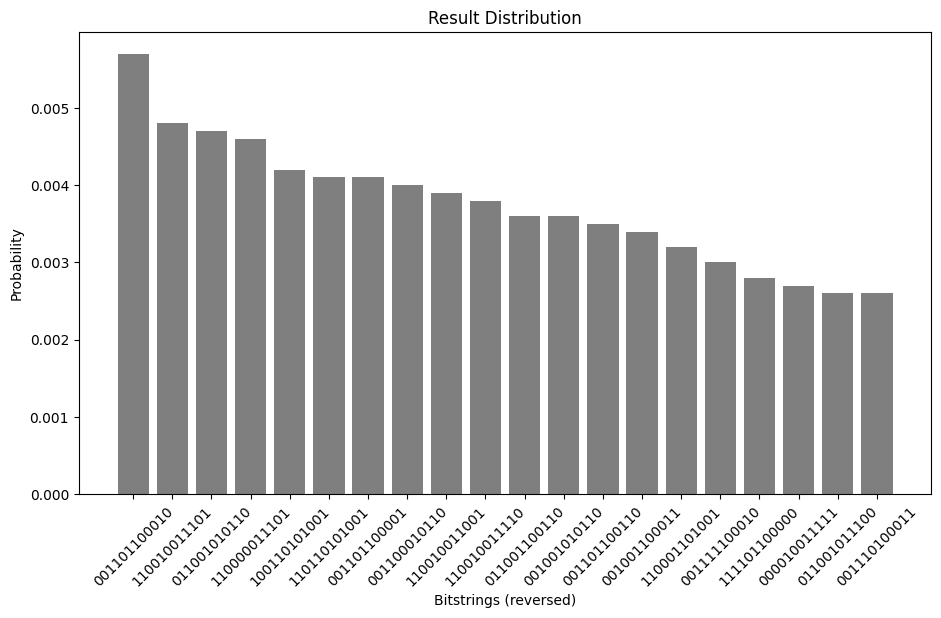

In [7]:
maxcut.plot_distribution()

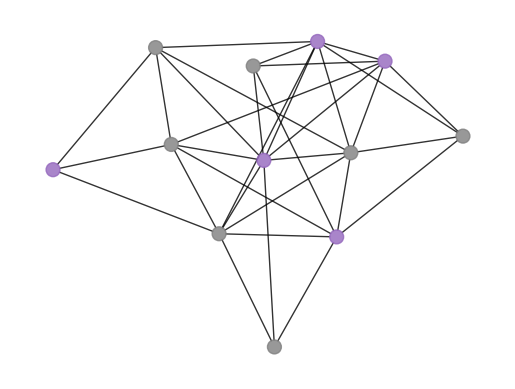

In [8]:
maxcut.draw_result(most_likely_bitstring)

In [9]:
from typing import Sequence
import rustworkx as rx 


def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value = evaluate_sample(most_likely_bitstring, maxcut.graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 24
